In [32]:
import math
import random
from tsplib95 import load
import matplotlib.pyplot as plt

def shufflePaths(num_total_destinations, num_of_population=8000):
    random_paths = []
    for _ in range(num_of_population):
        # Create a sequential path (1, 2, 3, ..., num_total_destinations)
        random_path = list(range(1, num_total_destinations + 1))
        random.shuffle(random_path)  # Shuffle the path
        
        # Ensure the path starts and ends at city 1
        random_path.remove(1)  # Remove 1 if present in the path
        random_path = [1] + random_path + [1]  # Add city 1 to start and end
        
        random_paths.append(random_path)
    return random_paths


def readFile(filename): # Load the file
    loaded = load(filename)
    return loaded


def calculate_total_path_distance(path, berlin):
    total_distance = 0
    for i in range(1, len(path)):
        prev_point = berlin.node_coords[path[i - 1]]
        curr_point = berlin.node_coords[path[i]]
        total_distance += math.dist(prev_point, curr_point)
    return round(total_distance, 2)


In [33]:
def elitism(paths, berlin, elite_pick):
    paths_total_distance = {calculate_total_path_distance(path, berlin): path for path in paths} # For all paths calculate their fitness score
    elitism_path = sorted(paths_total_distance.items(), key=lambda x: x[0]) # Sort the best paths by their distance score (Fitness score)
    return [path[1] for path in elitism_path[:elite_pick]]


In [34]:
def crossover(parent1, parent2, crossover_rate):
    size = len(parent1)
    
    if random.random() < crossover_rate: # just to determine whether crossover will take place.
        point1, point2 = sorted(random.sample(range(1, size - 1), 2)) # Select two random points 
        segment = parent1[point1:point2] # Get a segment from parent 
        remaining = [x for x in parent2 if x not in segment and x != 1] # Get remaining cities not in the segment 
        offspring = [1] + remaining[:point1] + segment + remaining[point1:] + [1] # Add city 1 to start and end, add the segment in between the remaining points.
        return offspring[:size] # Return the offspring
    
    # If crossover does not occur, return one of the parents
    return random.choice([parent1, parent2])

In [35]:
def order_crossover(parent1, parent2, crossover_rate):
    if random.random() >= crossover_rate:
        return random.choice([parent1, parent2])
        
    size = len(parent1)
    # Select substring boundaries
    start, end = sorted(random.sample(range(1, size - 1), 2))
    
    # Get substring from parent1
    substring = parent1[start:end]
    
    # Create remaining elements list in parent2 order
    remaining = [x for x in parent2 if x not in substring and x != 1]
    
    # Create offspring
    offspring = [1]  # Start with depot
    offspring.extend(remaining[:start-1])  # Add elements before substring
    offspring.extend(substring)  # Add substring
    offspring.extend(remaining[start-1:])  # Add remaining elements
    offspring.append(1)  # Return to city 1
    
    return offspring

In [36]:
def inversion_mutation(offspring, mutation_rate):
    for path in offspring:
        if random.random() < mutation_rate:
            pos1, pos2 = sorted(random.sample(range(1, len(path) - 1), 2)) # Select two positions
            path[pos1:pos2] = reversed(path[pos1:pos2]) # Reverse the substring
    return offspring

In [37]:
def swap_mutation(offspring, mutation_rate): # Function for swapping two points in a path
    for path in offspring:
        if random.random() < mutation_rate:
            idx1, idx2 = sorted(random.sample(range(1, len(path) - 1), 2))
            path[idx1], path[idx2] = path[idx2], path[idx1]
    return offspring

In [38]:

def plot_results(fitness_history, name): # Function to plot the results
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(fitness_history) + 1), fitness_history, marker='o', linestyle='-')
    plt.xlabel("Generation")
    plt.ylabel("Best Path Distance")
    plt.title("TSP Optimization Progress - " + name)
    plt.grid(True)
    plt.show()


In [39]:
import time

def run_evolution_crossover_mutation(berlin, num_generations=100, mutation_rate=0.3, elite_pick=10,num_of_population=20000,crossover_rate=0.5):
    history = []
    paths = shufflePaths(len(berlin.node_coords),num_of_population) # Create paths
    best_path, best_fitness = None, float('inf')
    print(" Starting Genetic Algorithm\n-----------------------------")
    start_time = time.time()   #Start tracking time
    
    initial_mutation_rate = mutation_rate  # Default mutation rate
    mutation_rate = initial_mutation_rate # Encase we need to reset to initial_mutation_rate
    no_improvement_count = 0  # Track consecutive stagnation generations

    for generation in range(num_generations):
        elite = elitism(paths, berlin, elite_pick) # get the best paths 
        offspring = [crossover(elite[i % 2], elite[(i + 1) % 2],crossover_rate) for i in range(len(elite))] # It loops over the elite list and selects two parents at a time.
        mutated_offspring = swap_mutation(offspring, mutation_rate) # Mutate the offspring of crossover 
        paths.extend(mutated_offspring) # Add offspring to paths
        current_best, current_best_fitness = min(((p, calculate_total_path_distance(p, berlin)) for p in paths), key=lambda x: x[1])#   
        initial_mutation_rate = mutation_rate
        mutation_rate = initial_mutation_rate  
        
        
         # Check if there is an improvement
        if history and current_best_fitness >= history[-1]:  
            no_improvement_count += 1  # Increment stagnation counter
        else:
            no_improvement_count = 0  # Reset if improvement occurs
    
        # Increase mutation rate if stuck for 5 generations
        if no_improvement_count >= 10:
            mutation_rate = min(mutation_rate + 0.05, 1)  # Max limit at 0.5
    
        # Decrease mutation rate slightly every 5 generations
        if generation % 5 == 0 and mutation_rate > initial_mutation_rate:
            mutation_rate = max(mutation_rate - 0.02, initial_mutation_rate)  # Reduce, but not below initial value

        
        history.append(current_best_fitness)  # Store fitness
        if current_best_fitness < best_fitness:
            best_path, best_fitness = current_best, current_best_fitness

            # Print progress
        if (generation + 1) % 10 == 0:
            print(
                f"Generation {generation + 1}: Best Fitness = {current_best_fitness:.2f} Mutation Rate = {mutation_rate:.2f} Crossover Rate = {crossover_rate:.2f}")
    end_time = time.time()  
    total_time = end_time - start_time 
    return best_path, best_fitness, history, total_time


In [40]:
def run_evolution_order_inversion(berlin, num_generations=100, mutation_rate=0.3, elite_pick=10,num_of_population=20000,crossover_rate=0.5):
    history = []
    paths = shufflePaths(len(berlin.node_coords),num_of_population)  
    best_path, best_fitness = None, float('inf') 
    print(" Starting Genetic Algorithm\n-----------------------------")
    start_time = time.time()  
    initial_mutation_rate = mutation_rate  # Default mutation rate
    mutation_rate = initial_mutation_rate
    no_improvement_count = 0  # Track consecutive stagnation generations

    for generation in range(num_generations):
        elite = elitism(paths, berlin, elite_pick)
        offspring = [order_crossover(elite[i % 2], elite[(i + 1) % 2], crossover_rate) for i in range(len(elite))]
        mutated_offspring = inversion_mutation(offspring, mutation_rate)
        paths.extend(mutated_offspring)
        current_best, current_best_fitness = min(((p, calculate_total_path_distance(p, berlin)) for p in paths), key=lambda x: x[1])

         # Check if there is an improvement
        if history and current_best_fitness >= history[-1]:  
            no_improvement_count += 1  # Increment stagnation counter
        else:
            no_improvement_count = 0  # Reset if improvement occurs
    
        # Increase mutation rate if stuck for 5 generations
        if no_improvement_count >= 10:
            mutation_rate = min(mutation_rate + 0.05, 1)  # Max limit at 0.5
    
        # Decrease mutation rate slightly every 5 generations
        if generation % 5 == 0 and mutation_rate > initial_mutation_rate:
            mutation_rate = max(mutation_rate - 0.02, initial_mutation_rate)  # Reduce, but not below initial value

        
        history.append(current_best_fitness)  # Store fitness
        if current_best_fitness < best_fitness:
            best_path, best_fitness = current_best, current_best_fitness

        if (generation + 1) % 10 == 0:
            print(
                f"Generation {generation + 1}: Best Fitness = {current_best_fitness:.2f} Mutation Rate = {mutation_rate:.2f} Crossover Rate = {crossover_rate:.2f}")
    end_time = time.time() 
    total_time = end_time - start_time 
    return best_path, best_fitness, history, total_time


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 21915.34 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 20: Best Fitness = 19624.63 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 30: Best Fitness = 18544.91 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 40: Best Fitness = 17556.97 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 50: Best Fitness = 16910.05 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 60: Best Fitness = 16086.25 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 70: Best Fitness = 15539.26 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 80: Best Fitness = 14674.02 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 90: Best Fitness = 13995.75 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 100: Best Fitness = 13830.52 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 110: Best Fitness = 13579.59 Mutation Rate = 0.11 Crossover Rate = 0.90
Generation 120: Best Fitness = 13579.5

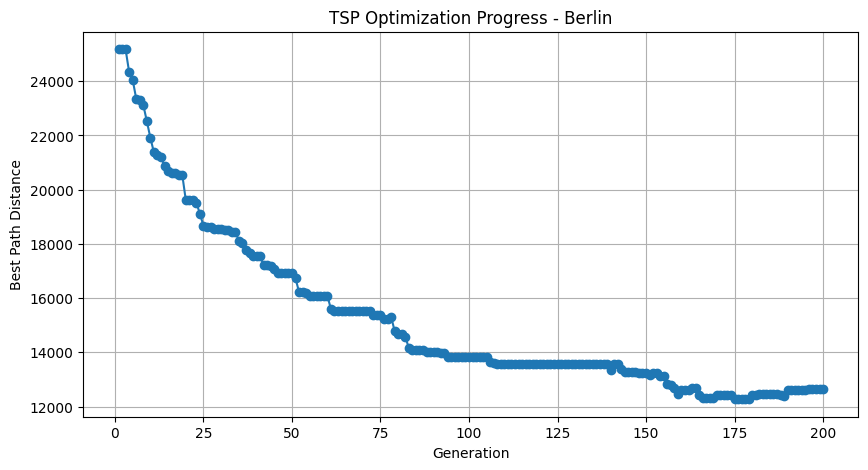

Total Time Taken: 7.23 seconds


In [41]:
# Berlin52 crossover_mutation
berlin = readFile("Dataset/berlin52.tsp")
best_path, best_fitness, history, duration = run_evolution_crossover_mutation(berlin, num_generations=200, mutation_rate=0.11, elite_pick=10, num_of_population=100, crossover_rate=0.9)
print(f"Path: {best_path}\nTotal Distance: {best_fitness:.2f} with Crossover & Swap Mutation")
plot_results(history,"Berlin")
print(f"Total Time Taken: {duration:.2f} seconds")


In [47]:
#Berlin52 order_inversion
berlin = readFile("Dataset/berlin52.tsp")
best_path, best_fitness, history, duration = run_evolution_order_inversion(berlin, num_generations=500, mutation_rate=0.05, elite_pick=75, num_of_population=3000, crossover_rate=0.85)
print(f"Path: {best_path}\nTotal Distance: {best_fitness:.2f} with Ordered Crossover & Inversion Mutation")
plot_results(history, "Berlin")
print(f"Total Time Taken: {duration:.2f} seconds")


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 19972.73 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 20: Best Fitness = 17534.38 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 30: Best Fitness = 16406.37 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 40: Best Fitness = 14043.57 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 50: Best Fitness = 12409.17 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 60: Best Fitness = 11881.24 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 70: Best Fitness = 11738.80 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 80: Best Fitness = 11592.30 Mutation Rate = 0.05 Crossover Rate = 0.85
Generation 90: Best Fitness = 11385.62 Mutation Rate = 0.08 Crossover Rate = 0.85
Generation 100: Best Fitness = 11385.62 Mutation Rate = 0.10 Crossover Rate = 0.85
Generation 110: Best Fitness = 11282.38 Mutation Rate = 0.36 Crossover Rate = 0.85
Generation 120: Best Fitness = 10993.0

KeyboardInterrupt: 

In [43]:
#KroA100 order_mutation
kr = readFile("Dataset/kroA100.tsp")
best_path, best_fitness, history, duration = run_evolution_crossover_mutation(kr, num_generations=500, mutation_rate=0.01, elite_pick=100, num_of_population=1000, crossover_rate=0.9)
print(f"\nkroA100: \nPath: {best_path}\nTotal Distance: {best_fitness:.2f} with Crossover & Swap Mutation")
plot_results(history, "KroA100")
print(f"Total Time Taken: {duration:.2f} seconds")


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 109172.12 Mutation Rate = 0.01 Crossover Rate = 0.90
Generation 20: Best Fitness = 95311.29 Mutation Rate = 0.01 Crossover Rate = 0.90
Generation 30: Best Fitness = 84909.09 Mutation Rate = 0.01 Crossover Rate = 0.90
Generation 40: Best Fitness = 75693.85 Mutation Rate = 0.01 Crossover Rate = 0.90
Generation 50: Best Fitness = 68479.33 Mutation Rate = 0.01 Crossover Rate = 0.90
Generation 60: Best Fitness = 64328.29 Mutation Rate = 0.01 Crossover Rate = 0.90


KeyboardInterrupt: 

In [57]:
#KroA100 order_inversion
kr = readFile("Dataset/kroA100.tsp")
best_path, best_fitness, history, duration = run_evolution_order_inversion(kr, num_generations=1000, mutation_rate=0.15, elite_pick=100, num_of_population=10000, crossover_rate=0.95)
print(f"\nkroA100: \nPath: {best_path}\nTotal Distance: {best_fitness:.2f} with Ordered Crossover & Inversion Mutation")
plot_results(history, "KroA100")
print(f"Total Time Taken: {duration:.2f} seconds")


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 101435.99 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 20: Best Fitness = 88441.81 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 30: Best Fitness = 77195.33 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 40: Best Fitness = 66481.25 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 50: Best Fitness = 58474.37 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 60: Best Fitness = 54169.66 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 70: Best Fitness = 49391.95 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 80: Best Fitness = 45441.39 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 90: Best Fitness = 42360.51 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 100: Best Fitness = 41758.39 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 110: Best Fitness = 40757.34 Mutation Rate = 0.15 Crossover Rate = 0.95
Generation 120: Best Fitness = 39159.

KeyboardInterrupt: 

In [58]:
#Pr1002 order_inversion
pr = readFile("Dataset/pr1002.tsp")
best_path, best_fitness, history, duration = run_evolution_order_inversion(pr, num_generations=1000, mutation_rate=0.25, elite_pick=25, num_of_population=100, crossover_rate=0.85)
print(f"\nPr1002: \nPath: {best_path}\nTotal Distance: {best_fitness:.2f} with Ordered Crossover & Inversion Mutation")
plot_results(history, "Pr1002")
print(f"Total Time Taken: {duration:.2f} seconds")


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 6075015.97 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 20: Best Fitness = 5962640.35 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 30: Best Fitness = 5853382.55 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 40: Best Fitness = 5727980.58 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 50: Best Fitness = 5626419.33 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 60: Best Fitness = 5520693.53 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 70: Best Fitness = 5427235.88 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 80: Best Fitness = 5329173.35 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 90: Best Fitness = 5225397.64 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 100: Best Fitness = 5152385.80 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 110: Best Fitness = 5063827.99 Mutation Rate = 0.25 Crossover Rate = 0.85
Generation 120: 

KeyboardInterrupt: 

In [27]:
#Pr1002 order_mutation
pr = readFile("Dataset/pr1002.tsp")
best_path, best_fitness, history, duration = run_evolution_crossover_mutation(pr, num_generations=1500, mutation_rate=0.1, elite_pick=25, num_of_population=100, crossover_rate=0.95)
print(f"\nPr1002: \nPath: {best_path}\nTotal Distance: {best_fitness:.2f} with Crossover & Swap Mutation")
plot_results(history, "Pr1002")
print(f"Total Time Taken: {duration:.2f} seconds")


 Starting Genetic Algorithm
-----------------------------
Generation 10: Best Fitness = 5953914.01 Mutation Rate = 0.10 Crossover Rate = 0.95
Generation 20: Best Fitness = 5820585.28 Mutation Rate = 0.10 Crossover Rate = 0.95


KeyboardInterrupt: 